# Simple preprocessing pipeline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy import stats

from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, learning_curve,\
train_test_split, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier, Ridge, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.compose import make_column_selector

## pipeline stuff

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display='diagram')

In [3]:
def_df = pd.read_csv("../raw_data/defaulter_data_13364.csv", index_col=[0])
pay_df = pd.read_csv("../raw_data/payer_data_41940.csv", index_col=[0])
def_df['default'] = 1
pay_df['default'] = 0

df = pd.concat([def_df, pay_df])

In [4]:
y = df['default'].reset_index(drop=True)

X = df.drop(columns=['default']).reset_index(drop=True)

Discarding columns if too highly correlated with other or too many Nans

In [5]:
cat_vars = ['B_30', 
            'B_38', 
            'D_114', 
            'D_116', 
            'D_117', 
            'D_120', 
            'D_126', 
            'D_63', 
            'D_64', 
            'D_66', 
            'D_68']

drop columns if they correlate > 95% with others

In [6]:
X_corr = X.corr()

In [7]:
X_corr = X_corr.unstack().reset_index() # Unstack correlation matrix 
X_corr.columns = ['feature_1','feature_2', 'correlation_all'] # rename columns
X_corr.sort_values(by="correlation_all",ascending=False, inplace=True) # sort by correlation
X_corr = X_corr[X_corr['feature_1'] != X_corr['feature_2']] # Remove self correlation
X_corr = X_corr.drop_duplicates(subset='correlation_all')

In [8]:
red_features = list(X_corr[abs(X_corr['correlation_all'])>=.95]['feature_1']) ## abs so we also consider the negative corrs

In [9]:
X_red = X.drop(columns=red_features) ## dropping the highly correlated columns

In [10]:
## checking whether the high correlations are gone
X_red_corr = X_red.corr()
X_red_corr = X_red_corr.unstack().reset_index() # Unstack correlation matrix 
X_red_corr.columns = ['feature_1','feature_2', 'correlation_all'] # rename columns
X_red_corr.sort_values(by="correlation_all",ascending=False, inplace=True) # sort by correlation
X_red_corr = X_red_corr[X_red_corr['feature_1'] != X_red_corr['feature_2']] # Remove self correlation
X_red_corr = X_red_corr.drop_duplicates(subset='correlation_all')

In [11]:
X_red_corr

,feature_1,feature_2,correlation_all
12045,D_74,D_58,0.927332
6471,B_13,B_12,0.921825
457,B_2,B_33,0.913250
728,S_3,S_7,0.903899
28001,D_131,D_132,0.891850
...,...,...,...
9398,B_20,B_2,-0.779728
5981,S_8,S_15,-0.783457
23888,B_39,B_17,-0.805295
11791,D_73,D_108,-0.851429


In [12]:
len(red_features) ## we removed 13 columns

13

drop columns with nans if in __both__ groups > 80% nans

In [13]:
nan_threshold= 0.8 ## adjust the hardcoded values

In [14]:
def_nans = def_df.isna().sum()/len(def_df) 

In [15]:
def_nans_80 = def_nans[def_nans >= 0.8].index

In [16]:
pay_nans = pay_df.isna().sum()/len(pay_df)

In [17]:
pay_nans_80 = pay_nans[pay_nans>=0.8].index

In [18]:
nans_80 = [feature for feature in pay_nans_80 if feature in def_nans_80]

In [19]:
## check whether features were already removed
red_features_nan = [feature for feature in nans_80 if feature not in red_features] 

In [20]:
X_red = X_red.drop(columns=red_features_nan)

In [21]:
dropped_columns = red_features + red_features_nan

Building the pipeline

In [22]:
num_vars = [feature for feature in X_red.columns[2:] if feature not in cat_vars] ## exclude dates and IDs (first two columns)
str_vars = [feature for feature in X_red.columns[2:] if not pd.api.types.is_numeric_dtype(X_red[feature])] ## columns that are not numeric at all 
red_cat_vars = [feature for feature in cat_vars if feature not in dropped_columns] ## remaining categorical variables that have no string values

mark rows in categorical columns with values of -1 as NaNs

In [23]:
#X_red[red_cat_vars] = X_red[red_cat_vars].applymap(lambda x: np.nan if x in [-1,-1.0, "-1.0", "-1"] else x)

In [24]:
def nan_imp(X): ## imputes nan values for alternative values signifying nans
    nan_list = [-1,-1.0, "-1.0", "-1"] 
    return X.applymap(lambda x: np.nan if x in nan_list else x) ## perhaps subfunctions for arrays

In [25]:
# impute mean/most frequent value for other nans (specific to group?)
# robustscale all numerical values

num_scaler = RobustScaler()
num_imputer = SimpleImputer(strategy='mean')
#num_imputer = KNNImputer(n_neighbors=2) ## KNNIMputer is computationally demanding
## should come AFTER SCALING

num_pipe = make_pipeline(num_scaler, num_imputer)

str_trans = OrdinalEncoder() # is only needed if one wants to do knnimputer

nan_trans = FunctionTransformer(nan_imp)
cat_imputer = SimpleImputer(strategy="most_frequent") ## replace with KNNimputer on one neighbour, after transforming to numericals
#cat_imputer = KNNImputer(n_neighbors=1) # introducing it did not improve performance, but is computationally demanding
cat_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') ## what happens to the old columns?
cat_pipe = make_pipeline(nan_trans, cat_imputer, cat_encoder)
str_pipe = make_pipeline(nan_trans, str_trans, cat_imputer, cat_encoder)

Beware of the Dummy trap. OneHotEncoder automatically deletes one column.

In [26]:
str_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function nan_imp at 0x123982670>)),
                ('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [27]:
preprocessor = ColumnTransformer([
    ('num_pip', num_pipe, num_vars),
    ('cat_pip', cat_pipe, red_cat_vars), 
    ('str_pip', str_pipe, str_vars)],
    remainder='drop' ## all columns not in num_vars and red_cat_vars are dropped.
)

In [28]:
preprocessor

ColumnTransformer(transformers=[('num_pip',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 ['P_2', 'D_39', 'B_2', 'R_1', 'S_3', 'D_41',
                                  'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45',
                                  'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49',
                                  'B_6', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3',
                                  'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'S_6', ...]),
                                ('cat_pip',
                                 Pipeline(s...
                                 ['B_30', 'B_38', 'D_114', 'D_116', 'D_117',
                                  'D_120', 'D_126', 'D_63', 'D_64', 'D_68']),
                                ('str_pip',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function nan_imp at 0x123982670>)),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['D_63', 'D_64'])])

In [29]:
preprocessor.fit(X_red)

ColumnTransformer(transformers=[('num_pip',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 ['P_2', 'D_39', 'B_2', 'R_1', 'S_3', 'D_41',
                                  'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45',
                                  'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49',
                                  'B_6', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3',
                                  'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'S_6', ...]),
                                ('cat_pip',
                                 Pipeline(s...
                                 ['B_30', 'B_38', 'D_114', 'D_116', 'D_117',
                                  'D_120', 'D_126', 'D_63', 'D_64', 'D_68']),
                                ('str_pip',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function nan_imp at 0x123982670>)),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['D_63', 'D_64'])])

## aggregations

In [30]:
X_pp = pd.DataFrame(preprocessor.transform(X_red))

In [31]:
X_pp

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,-0.432532,1.390477,0.219561,0.633174,1.052237,0.377275,0.112275,0.107377,1.289006,0.861310,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.590602,-0.024268,0.004731,85.887104,0.417020,-0.753076,0.035995,1.706369,1.245628,-0.012141,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.590359,0.365948,0.005088,85.474799,0.588708,-0.628862,0.125662,0.310612,0.391219,5.811345,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.644202,-0.027197,0.214465,0.403981,0.721292,0.464084,0.095199,0.310612,0.384427,5.817559,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.568984,0.374308,0.003306,86.646623,-0.069924,-0.861669,0.113541,0.310612,2.925453,4.838007,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55299,0.268886,-0.028833,-0.004019,-0.765108,2.473778,-0.502812,-0.050748,0.310612,0.467831,0.861310,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
55300,0.256161,-0.037582,0.002408,0.116283,0.108060,-0.137992,0.026207,0.310612,0.467831,0.861310,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
55301,0.260653,-0.016493,-0.001604,0.424582,0.080116,0.053407,-0.008005,0.310612,0.467831,0.861310,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
55302,0.255417,-0.016073,-0.004165,-0.560179,0.054235,0.670990,-0.065415,0.310612,0.467831,0.861310,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
X_red[red_cat_vars].nunique().sum() ## number of unqie values in all cat. values
## should equal the number of new onehotencoded columns - 1*number of features. The latter to avoid Dummy Trap.


43

Building the simple model and putting it into the pipe

In [33]:
mod = LogisticRegression() 
## such a model treats all rows as independent despite them being from the same person
results = cross_validate(mod, X_pp, y, cv = 5, scoring=['accuracy', 'recall', 'f1'])

/Users/huhuzl/.pyenv/versions/3.8.12/envs/AMEX_predict_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/huhuzl/.pyenv/versions/3.8.12/envs/AMEX_predict_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

In [34]:
results

{'fit_time': array([1.59151411, 1.255723  , 1.31548595, 1.35600591, 1.46629095]),
 'score_time': array([0.02091789, 0.01357913, 0.01129007, 0.02152896, 0.01748919]),
 'test_accuracy': array([0.84070156, 0.84187686, 0.85173131, 0.85155049, 0.84041591]),
 'test_recall': array([0.62888141, 0.59259259, 0.63561541, 0.63561541, 0.60778443]),
 'test_f1': array([0.65612802, 0.6442953 , 0.674474  , 0.67420635, 0.64791542])}

In [ ]:
#

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_pp, y, test_size=0.3)

In [37]:
mod = LogisticRegression() 
mod.fit(X_train,y_train)

/Users/huhuzl/.pyenv/versions/3.8.12/envs/AMEX_predict_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
y_train.head()

27734    0
44682    0
14244    0
14240    0
48705    0
Name: default, dtype: int64

In [59]:
# Create a SHAP Explainer
explainer = shap.Explainer(mod,X_train)

# Calculate the Shap values
feature_values=X_val.iloc[5,:]
# Giving as input the feature values for the instance I'm looking at
shap_values_one = explainer(X_val)

In [60]:
type(explainer)

shap.explainers._linear.Linear

AttributeError: 'int' object has no attribute 'split'

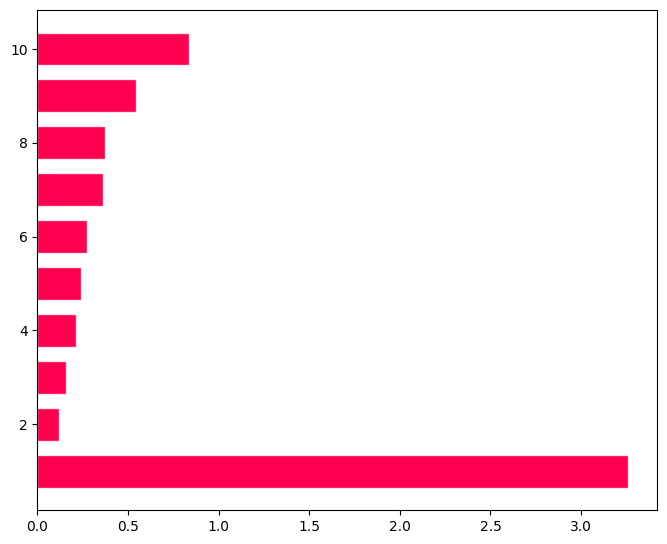

In [57]:
shap.plots.bar(shap_values_one)

In [44]:
import shap
rf_shap_values = shap.KernelExplainer(mod.predict,X_val)


Using 16592 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [46]:
print(rf_shap_values.shap_values(X_val))


  0%|                                                 | 0/16592 [01:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pp_pred_pipe = make_pipeline(preprocessor, mod)

In [ ]:
pp_pred_pipe

In [ ]:
pp_pred_pipe.fit(X_train, yy_train)

# Trying pickling

In [ ]:
# # import pickle

# # pickle.dump(pp_pred_pipe, open('pp_pred_pipe', 'wb'))

# # loaded_model = pickle.load(open('../pickles/pp_pred_pipe', 'rb'))



# sample = X_red.sample(1)

# loaded_model.predict_proba(sample)[0][1] * 100

# Creating custom amex scoring metric

In [ ]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    
    ## TWEAK
    y_true = pd.DataFrame(y_true.reset_index(drop=True))
    y_pred = pd.DataFrame(y_pred)
    
    y_true = y_true.rename(columns={y_true.columns[0]:'target'})
    y_pred = y_pred.rename(columns={y_pred.columns[0]:'prediction'})
    ##
    
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [ ]:
from sklearn.metrics import make_scorer

make_scorer()

In [ ]:
amex_metric_scorer = make_scorer(amex_metric)

In [ ]:
## dict of scoring metrics one might want to pass into cross validation
scorings = {'recall':'recall',
            'f1':'f1',
           'amex': amex_metric_scorer}

In [ ]:
from 

# Averaging preprocessed X and y

In [ ]:
X_pp['customer_ID'] = X_red['customer_ID']

In [ ]:
X_avg_pp = X_pp.groupby('customer_ID').mean()

In [ ]:
y.head()

In [ ]:
y_ID = pd.DataFrame(y)

In [ ]:
y_ID.head()

In [ ]:
y_ID['customer_ID'] = X_red['customer_ID']

In [ ]:
y_unique = y_ID.groupby('customer_ID').mean().astype(int) ## actually, this data is just in train_labels

In [ ]:
y_unique.head()

# Trying out various models on averaged data

In [ ]:
mod = LogisticRegression() 
## such a model treats all rows as independent despite them being from the same person
results = cross_validate(mod, X_avg_pp, y_unique['default'], cv = 5, scoring=scorings)

In [ ]:
results

In [ ]:
!pip install shap

In [ ]:
import shap  # To install SHAP: pip install shap

# Run the following command. Needed for some visualizations.
shap.initjs()

In [ ]:
# Create a SHAP Explainer
explainer = shap.Explainer(mod.predict,X_avg_pp)

In [ ]:


# Calculate the Shap values
# Giving as input the feature values for the instance I'm looking at
feature_values=X_avg_pp.iloc[5,:]
shap_values_one = explainer(feature_values)

In [ ]:
X_avg_pp.head()

In [ ]:
cross_val_predict(mod, X_avg_pp, y_unique['default'], cv = 5, scoring=scorings, method='predict_proba')

In [ ]:
mod = LogisticRegression(penalty='l1',solver='liblinear') 
## such a model treats all rows as independent despite them being from the same person
results = cross_validate(mod, X_avg_pp, y_unique, cv = 5, scoring=scorings)

In [ ]:
results

In [ ]:
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier

In [ ]:
mod_perc = Perceptron(penalty='l1')

In [ ]:
results_perc = cross_validate(mod_perc, X_avg_pp, y_unique, cv = 5, scoring=scorings)
results_perc['test_recall'].mean()

In [ ]:
results

In [ ]:
mod_agg = PassiveAggressiveClassifier()
results_agg = cross_validate(mod_agg, X_avg_pp, y_unique, cv = 5, scoring=scorings)
results_agg

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
results_knn = cross_validate(knn, X_avg_pp, y_unique, cv = 5, scoring=scorings)
results_knn['test_recall'].mean()

In [ ]:
results_knn

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
mod_gbc = GradientBoostingClassifier()

In [ ]:
results_gbc = cross_validate(mod_gbc, X_avg_pp, y_unique, cv = 5, scoring=scorings)
results_gbc

In [ ]:
results_gbc

# Trying out with predict_proba

In [ ]:
pp_pred_pipe_gbc = make_pipeline(preprocessor, mod_gbc)

In [ ]:
pp_pred_pipe_gbc.fit(X_train, y_train);

In [ ]:
y_pred = pp_pred_pipe_gbc.predict_proba(X_val)[:,1]

In [ ]:
amex_metric(y_val, y_pred)

Prepare for pickle that will be used on new data

In [ ]:
mod_gbc_ws = GradientBoostingClassifier(warm_start=True) ## makes the model incrementally trainable
pp_pred_pipe_gbc_ws = make_pipeline(preprocessor, mod_gbc_ws)
pp_pred_pipe_gbc_ws.fit(X, y);

In [ ]:
import pickle

pickle.dump(pp_pred_pipe_gbc_ws, open('../pickles/pp_pred_pipe_gbc_ws.pkl', 'wb'))

# # loaded_model = pickle.load(open('../pickles/pp_pred_pipe', 'rb'))



# sample = X_red.sample(1)

# loaded_model.predict_proba(sample)[0][1] * 100

In [ ]:
mod = LogisticRegression(penalty='l1',solver='liblinear') 
pp_pred_pipe_log = make_pipeline(preprocessor, mod)
pp_pred_pipe_log.fit(X_train, y_train);

In [ ]:
y_pred = pp_pred_pipe_log.predict_proba(X_val)[:,1]

In [ ]:
amex_metric(y_val, y_pred)

In [ ]:
mod = LogisticRegression(penalty='l1',solver='liblinear', warm_start=True) 

In [ ]:
pp_pred_pipe_log = make_pipeline(preprocessor, mod)
pp_pred_pipe_log.(X_train, y_train);

# more efficient way to drop NANs

In [ ]:
X.dropna(axis=1, thresh=int(0.2*len(X))) 
## however, here you cannot specify that it should be nns of 80% in BOTH groups